In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import itertools
from sklearn.model_selection import train_test_split
#from tpot import TPOTRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import LocallyLinearEmbedding, MDS
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
#Load Data
train = pd.read_csv(r'/content/Train_data.csv')
test = pd.read_csv(r'/content/Test_data.csv')

print("Training data has {} rows & {} columns".format(train.shape[0],train.shape[1]))

print(test.head(4))

print("Testing data has {} rows & {} columns".format(test.shape[0],test.shape[1]))

train.describe()

#print(train['num_outbound_cmds'].value_counts())
#print(test['num_outbound_cmds'].value_counts())

#'num_outbound_cmds' is a redundant column so remove it from both train & test datasets
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

Training data has 25192 rows & 42 columns
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp   private  REJ          0          0     0   
1         0           tcp   private  REJ          0          0     0   
2         2           tcp  ftp_data   SF      12983          0     0   
3         0          icmp     eco_i   SF         20          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_count  dst_host_srv_count  \
0               0       0    0  ...             255                  10   
1               0       0    0  ...             255                   1   
2               0       0    0  ...             134                  86   
3               0       0    0  ...               3                  57   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.04                    0.06   
1                    0.00                    0.06   
2                    0.61                    0.04   
3        

In [ ]:
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

In [ ]:
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets 
cattrain = train.select_dtypes(include=['object']).copy()
cattest = test.select_dtypes(include=['object']).copy()

# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# separate target column from encoded data 
enctrain = traincat.drop(['class'], axis=1)
cat_Ytrain = traincat[['class']].copy()

In [ ]:
#Union of processed numerical and categorical data
train_x = pd.concat([sc_traindf,enctrain],axis=1)
train_y = cat_Ytrain
train_x.shape

test_df = pd.concat([sc_testdf,testcat],axis=1)
test_df.shape

(22544, 40)

<ipython-input-6-ce523a56849f>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(train_x, train_y);


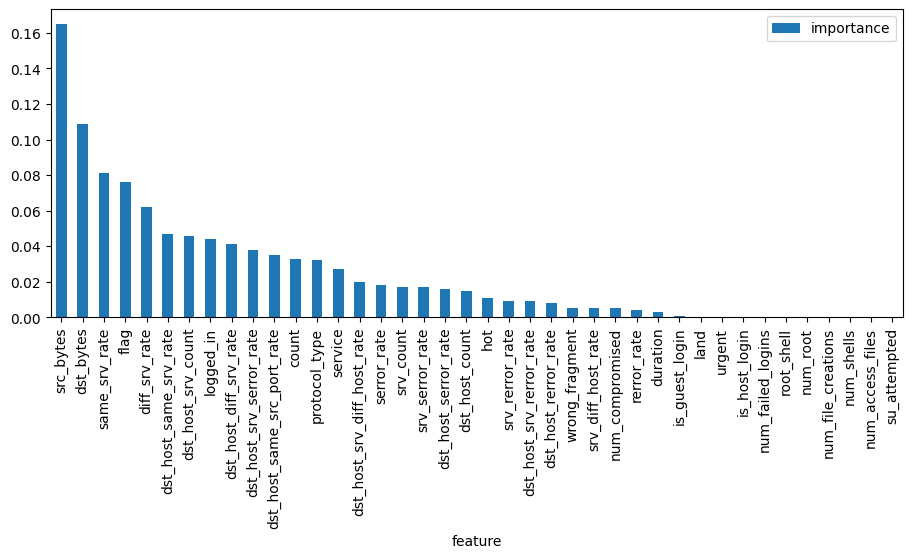

In [ ]:
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(train_x, train_y);

# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [ ]:

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(train_x, train_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_rfe.py:299: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_rfe.py:299: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_rfe.py:299: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_rfe.py:299: DataConversionWarning: A column-vector y was passed when a 1d array was expe

['src_bytes',
 'dst_bytes',
 'count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'protocol_type',
 'service',
 'flag']

In [ ]:
a = [i[0] for i in feature_map]

train_x = train_x.iloc[:,a]
test_df = test_df.iloc[:,a]

train_x.shape

(25192, 10)

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(train_x,train_y,train_size=0.70, random_state=2)
input_shape = [X_train.shape[1]]

In [ ]:
#SVM MODEL

model_svm = SVC(random_state=1)
model_svm.fit(X_train, Y_train)
y_pred_svm = model_svm.predict(X_test)
print(classification_report(Y_test, y_pred_svm))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.97      0.91      0.94      3498
           1       0.93      0.98      0.95      4060

    accuracy                           0.95      7558
   macro avg       0.95      0.95      0.95      7558
weighted avg       0.95      0.95      0.95      7558



0.9483990473670283

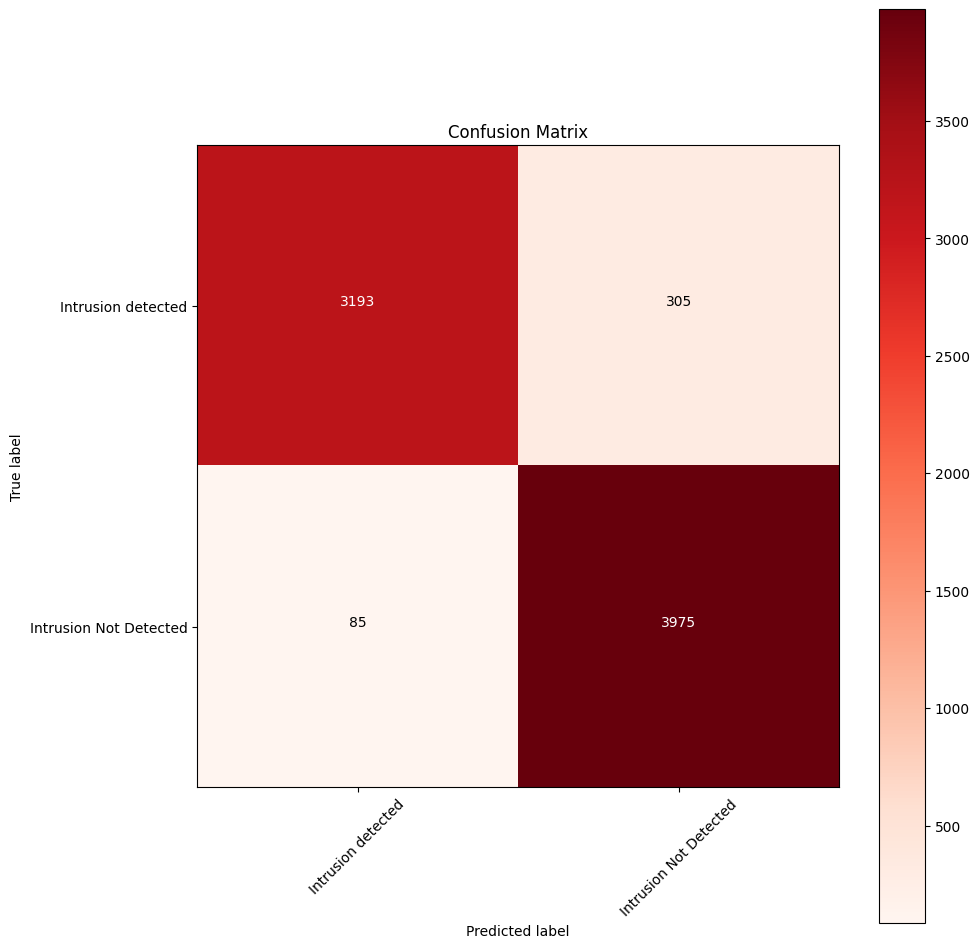

In [ ]:
#===========================CONSTRUCTING THE CONFUSION MATRIX=============================#
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm = confusion_matrix(Y_test, y_pred_svm)
target_names = ["Intrusion detected", "Intrusion Not Detected"]
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
accuracy_score(Y_test, y_pred_svm)

roc_auc_score for SVM:  0.9459356789382815


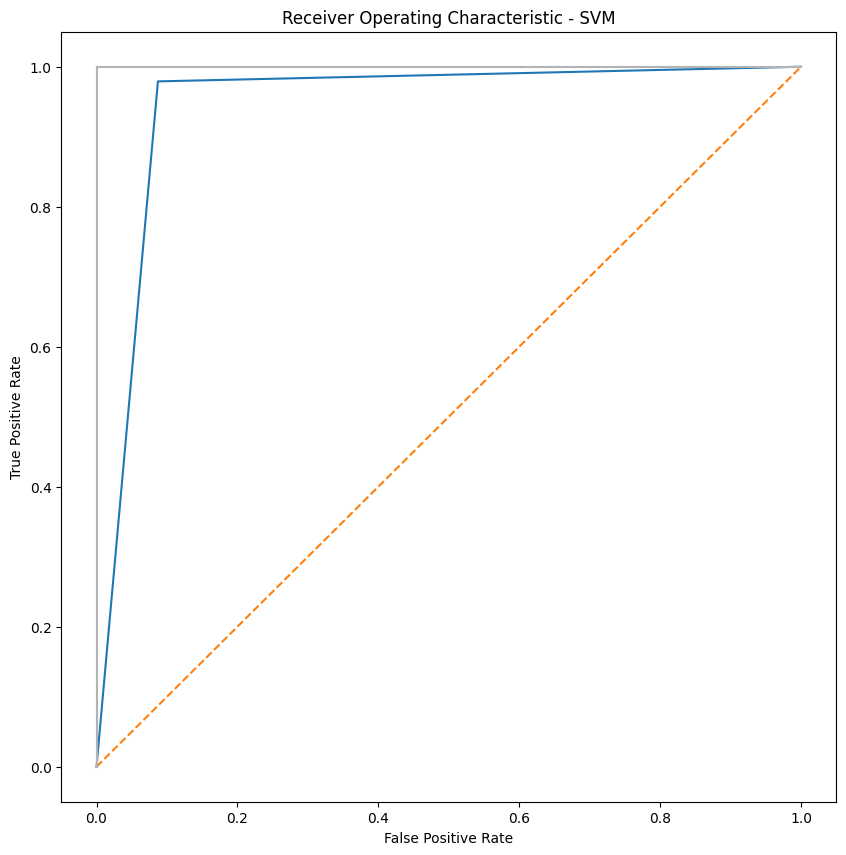

In [ ]:
# plot for SVM
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, y_pred_svm)
print('roc_auc_score for SVM: ', roc_auc_score(Y_test, y_pred_svm))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - SVM')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#KNN model

model_KNN = KNeighborsClassifier()
model_KNN.fit(X_train, Y_train)
y_pred_KNN = model_KNN.predict(X_test)
print(classification_report(Y_test, y_pred_KNN))

/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3498
           1       0.99      0.98      0.99      4060

    accuracy                           0.98      7558
   macro avg       0.98      0.98      0.98      7558
weighted avg       0.98      0.98      0.98      7558



0.9846520243450648

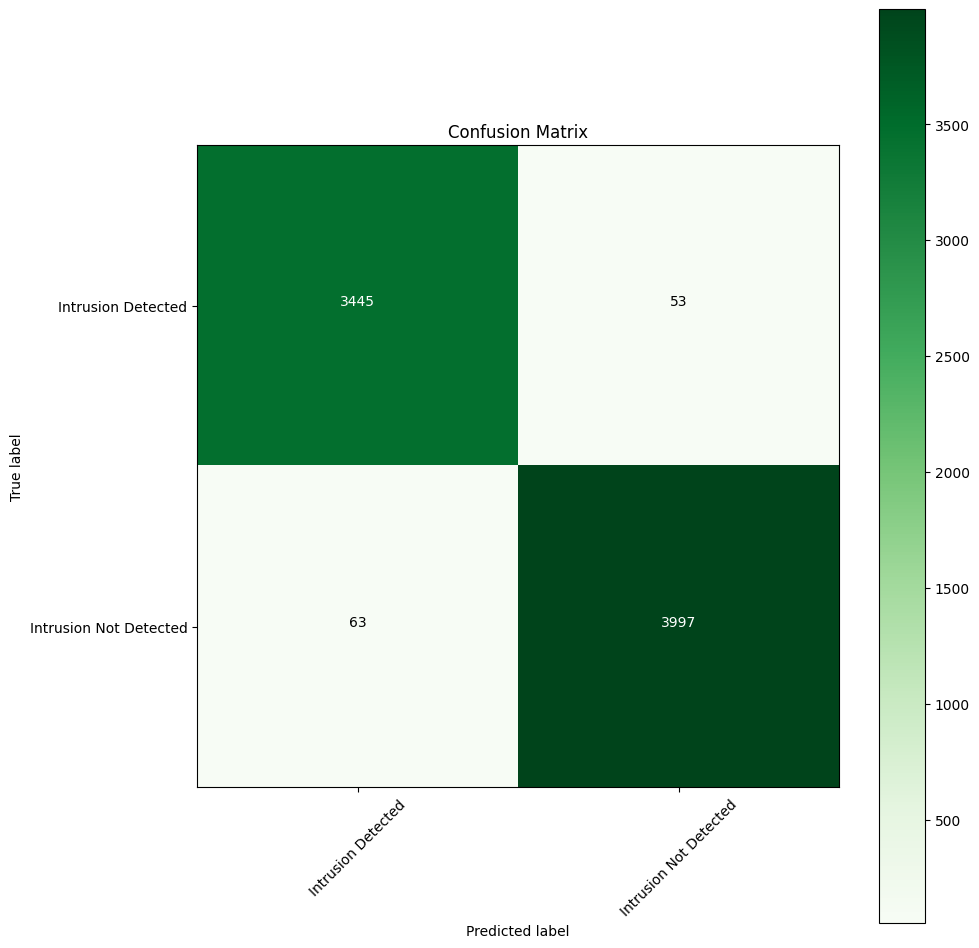

In [ ]:
#===========================CONSTRUCTING THE CONFUSION MATRIX=============================#
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Greens):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm = confusion_matrix(Y_test, y_pred_KNN)
target_names = ["Intrusion Detected", "Intrusion Not Detected"]
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
accuracy_score(Y_test, y_pred_KNN)

roc_auc_score for KNN:  0.9846656217345873


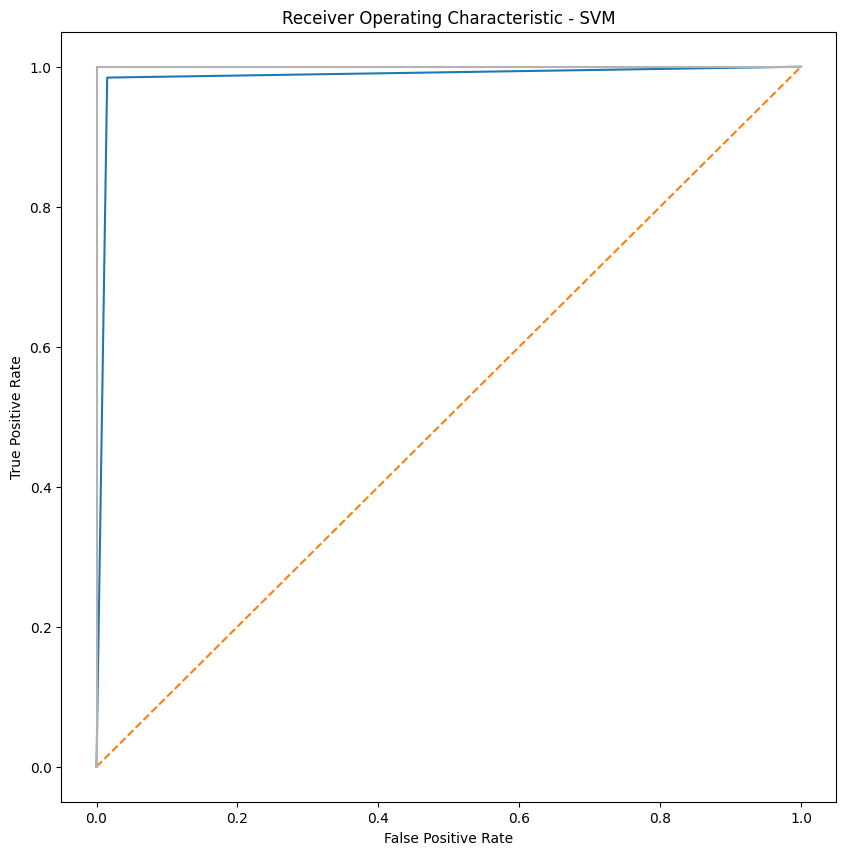

In [ ]:
# plot for KNN
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, y_pred_KNN)
print('roc_auc_score for KNN: ', roc_auc_score(Y_test, y_pred_KNN))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - SVM')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
model_RFC = RandomForestClassifier()
model_RFC.fit(X_train, Y_train)
y_pred_RFC = model_RFC.predict(X_test)
print(classification_report(Y_test, y_pred_RFC))

<ipython-input-17-4ab93fa63b69>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_RFC.fit(X_train, Y_train)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3498
           1       1.00      1.00      1.00      4060

    accuracy                           1.00      7558
   macro avg       1.00      1.00      1.00      7558
weighted avg       1.00      1.00      1.00      7558



0.9964276263561789

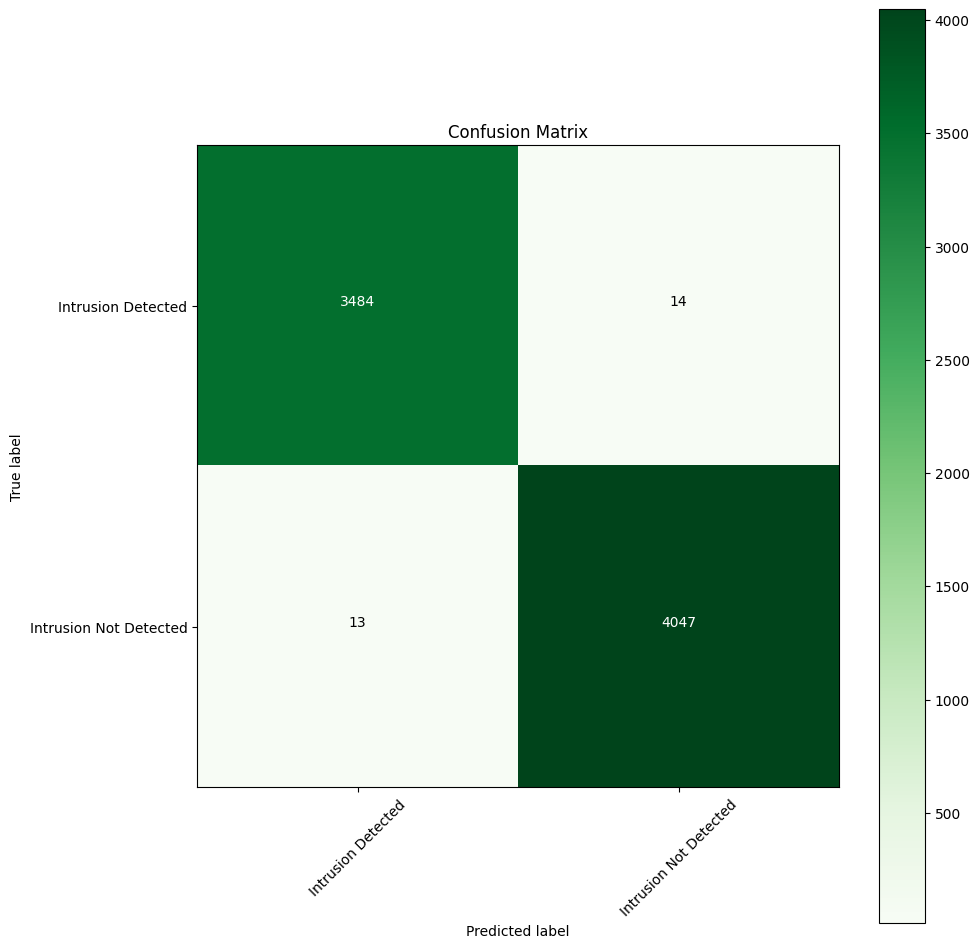

In [ ]:
#===========================CONSTRUCTING THE CONFUSION MATRIX=============================#
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Greens):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm = confusion_matrix(Y_test, y_pred_RFC)
target_names = ["Intrusion Detected", "Intrusion Not Detected"]
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
accuracy_score(Y_test, y_pred_RFC)

roc_auc_score for RFC:  0.9963978712677476


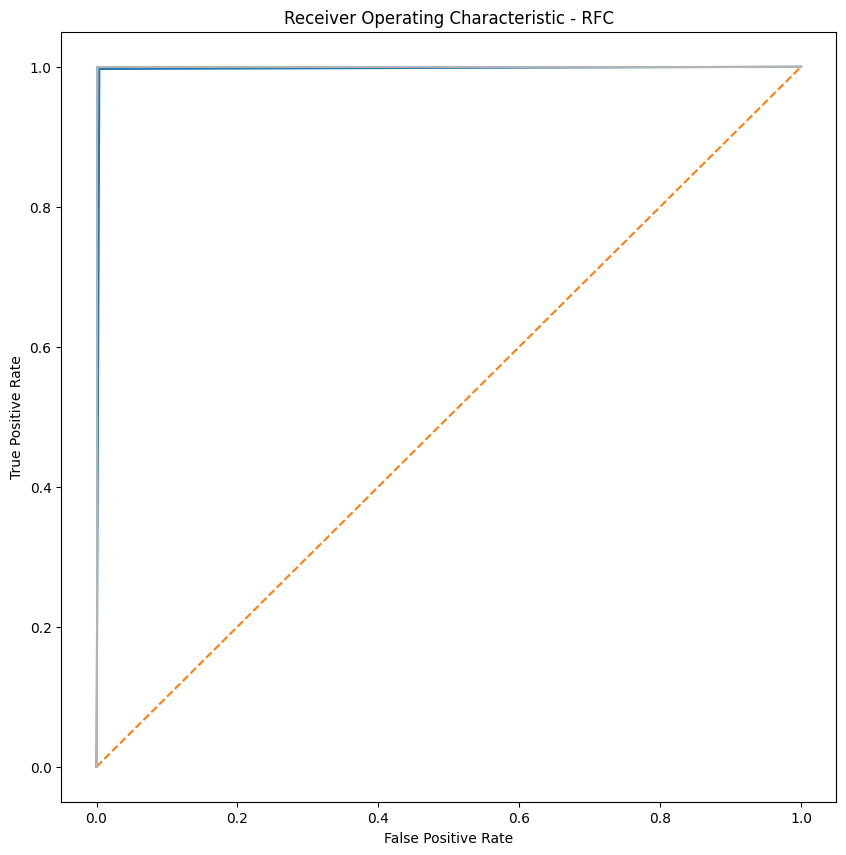

In [ ]:
# plot for RFC
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, y_pred_RFC)
print('roc_auc_score for RFC: ', roc_auc_score(Y_test, y_pred_RFC))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - RFC')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()